In [1]:
!rm -rf YOLOv8-Lightweight-Backbones
!git clone https://github.com/Brintsov/YOLOv8-Lightweight-Backbones

Cloning into 'YOLOv8-Lightweight-Backbones'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 82 (delta 11), reused 34 (delta 8), pack-reused 37 (from 1)
Receiving objects: 100% (82/82), 109.02 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (21/21), done.


# Import packages, including model creation and utility functions

In [4]:
import numpy as np
from keras_cv import visualization
from data.prepate_data import run_data_preparation_pipeline
from models.csp_darknet import create_xs_csp_darknet_yolov8
from models.ghostnet_v2 import create_0_5_ghostnet_yolov8
from models.shufflenet_v2 import create_0_5_shufflenet_yolov8

from keras.callbacks import CSVLogger
from profiling.coco_metric_callback import EvaluateCOCOMetricsCallback


# Create helper function to visualise detections with inferences

In [5]:
def visualize_detections(dataset, model=None, bounding_box_format="xyxy"):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = None
    if model:
        y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred if y_pred is not None else y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=cat_mapping,
    )

# Perform data preparation pipeline

1. Parse data from kaggle `"trainingdatapro/cars-video-object-tracking"` using kagglehub package
2. Process annotation `.xml` and convert it to DataFrame
3. Process images with rescaling and data augmentation
4. Convert data into Ragged Batch using `keras_cv`, described in Keras documentation `https://keras.io/examples/vision/yolov8/`
5. Divide into train/test

In [6]:
gathered_data = run_data_preparation_pipeline()

100%|██████████| 1.67G/1.67G [01:15<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/trainingdatapro/cars-video-object-tracking/versions/3


In [20]:
train_ds, val_ds = gathered_data['train_ds'], gathered_data['val_ds']
cat_mapping_r = gathered_data['cat_mapping_r']
cat_mapping = gathered_data['cat_mapping']

In [21]:
num_classes = 2
input_shape = (640, 640, 3)

BATCH_SIZE = 32
EPOCH = 50

# Create models

In [22]:
model_shuffle = create_0_5_shufflenet_yolov8(num_classes=num_classes, input_shape=input_shape)
csp_darknet_yolo = create_xs_csp_darknet_yolov8(num_classes=num_classes)
ghost_model = create_0_5_ghostnet_yolov8(num_classes=num_classes, input_shape=input_shape)

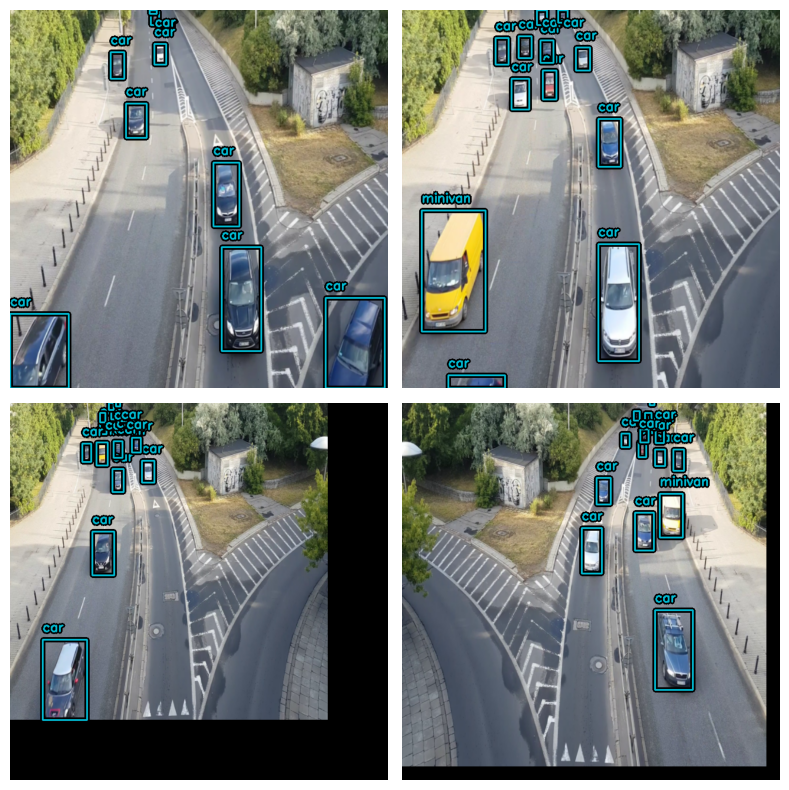

In [23]:
visualize_detections(
    train_ds, bounding_box_format="xyxy"
)

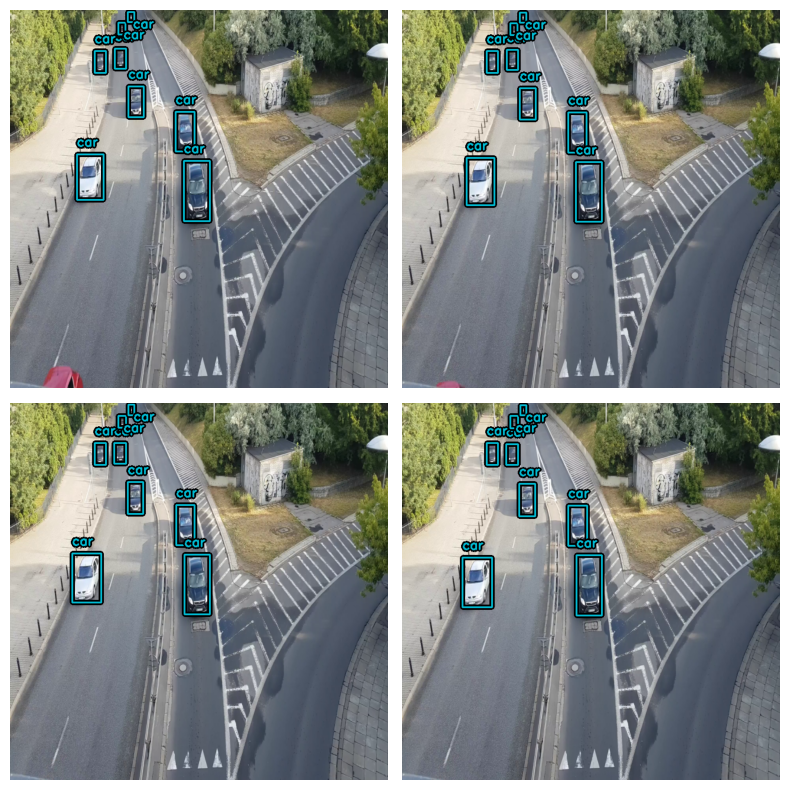

In [24]:
visualize_detections(
    val_ds, bounding_box_format="xyxy"
)

# Perform training

Below training were perform using GoogleColab Notebook with using it's free tier GPU

In [25]:
model_shuffle.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "best_shuffle_yolo_weights.keras"),
        CSVLogger("model_shuffle_training_history.csv", separator=",", append=False)
      ],

)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 488ms/step - box_loss: 3.9306 - class_loss: 224.2351 - loss: 228.1657 - val_box_loss: 5.1835 - val_class_loss: 70.5968 - val_loss: 75.7803 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - box_loss: 2.9897 - class_loss: 48.5198 - loss: 51.5095 - val_box_loss: 4.2074 - val_class_loss: 21.3192 - val_loss: 25.5267 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 -

In [26]:
csp_darknet_yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "best_darknet_yolo_weights.keras"),
        CSVLogger("model_darknet_training_history.csv", separator=",", append=False)
      ],

)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 416ms/step - box_loss: 3.9037 - class_loss: 289.5530 - loss: 293.4567 - val_box_loss: 5.3059 - val_class_loss: 79.4532 - val_loss: 84.7591 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - box_loss: 2.7069 - class_loss: 47.5063 - loss: 50.2131 - val_box_loss: 5.0331 - val_class_loss: 42.6559 - val_loss: 47.6890 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 -

In [ ]:
ghost_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    callbacks=[
        EvaluateCOCOMetricsCallback(val_ds, "best_ghost_yolo_weights.keras"),
        CSVLogger("model_ghost_training_history.csv", separator=",", append=False)
      ],

)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 451ms/step - box_loss: 3.6924 - class_loss: 280.7553 - loss: 284.4477 - val_box_loss: 5.1861 - val_class_loss: 113.1390 - val_loss: 118.3251 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - box_loss: 2.6728 - class_loss: 62.2963 - loss: 64.9690 - val_box_loss: 5.1678 - val_class_loss: 61.0239 - val_loss: 66.1917 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00

# Display model predictions

In [ ]:
visualize_detections(val_ds, model_shuffle)

In [ ]:
visualize_detections(csp_darknet_yolo, model_shuffle)

In [ ]:
visualize_detections(ghost_model, model_shuffle)